In [1]:
import laspy #read LAS
from laspy import file #read point cloud
import whitebox 
import osgeo.ogr as ogr
import osgeo.osr as osr
import shapefile #read SHP file
import rasterio #read TIFF file

import cv2
from scipy import ndimage as ndi
from scipy import spatial
from skimage import io
from skimage.measure import regionprops
from skimage.morphology import disk, dilation, erosion, remove_small_objects
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import math
import os
from tqdm import tqdm

In [2]:
# Determine the point coordinates before the perspective transformation according to the points in the SHP file
sf = shapefile.Reader(r"D:\Jizhou_UK\DFW\Late\las\DFW_late_mtps.shp",'rb')

shapes = sf.shapes()

list_p = []
num=0
for i in shapes:
    list_p.append(shapes[num].points[0])
    num+=1
    
dataset = rasterio.open(r"D:\Jizhou_UK\DFW\Late\las\190711\DFW_late_190711_chm.tif")

upper_left_x, upper_left_y = (list_p[0][0],list_p[0][1])
upper_left_row, upper_left_col = dataset.index(upper_left_x, upper_left_y)

lower_left_x, lower_left_y = (list_p[1][0],list_p[1][1])
lower_left_row, lower_left_col = dataset.index(lower_left_x, lower_left_y)

upper_right_x, upper_right_y = (list_p[3][0],list_p[3][1])
upper_right_row, upper_right_col = dataset.index(upper_right_x, upper_right_y)

lower_right_x, lower_right_y = (list_p[2][0],list_p[2][1])
lower_right_row, lower_right_col = dataset.index(lower_right_x, lower_right_y)

print(upper_left_row, upper_left_col, lower_left_row, lower_left_col, upper_right_row, upper_right_col, 
      lower_right_row, lower_right_col)

-1 212 3387 0 440 7163 3830 6946


In [3]:
#Determine width and height 
columns_1 = np.int(math.sqrt((upper_left_row-lower_left_row)**2
                              + (upper_left_col-lower_left_col)**2))
columns_2 = np.int(math.sqrt((upper_right_row-lower_right_row)**2
                              + (upper_right_col-lower_right_col)**2))
columns = np.max((columns_1,columns_2))

rows_1 = np.int(math.sqrt((upper_left_row-upper_right_row)**2
                           + (upper_left_col-upper_right_col)**2))
rows_2 = np.int(math.sqrt((lower_left_row-lower_right_row)**2
                           + (lower_left_col-lower_right_col)**2))
rows = np.max((rows_1,rows_2))
print(rows,columns)

6964 3396


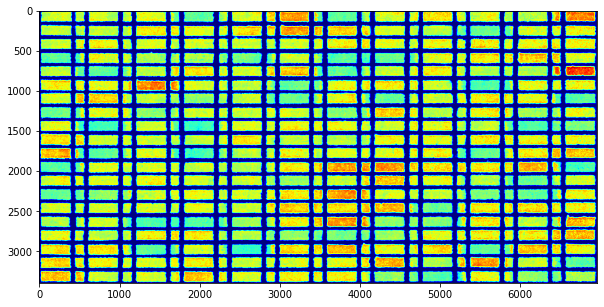

In [4]:
img_tif = io.imread(r"D:\Jizhou_UK\DFW\Late\las\190711\DFW_late_190711_chm.tif")

pts1 = np.float32([[upper_left_col,upper_left_row],[upper_right_col,upper_right_row],[lower_left_col,lower_left_row],
                   [lower_right_col,lower_right_row]])
pts2 = np.float32([[0,0],[rows,0],[0,columns],[rows,columns]])
M_PT = cv2.getPerspectiveTransform(pts1,pts2)

inverse_M_PT = np.linalg.inv(M_PT)

dst_PT = cv2.warpPerspective(img_tif,M_PT,(rows,columns))

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dst_PT,cmap='jet',vmin = 0, vmax = 1)

31518.0
240


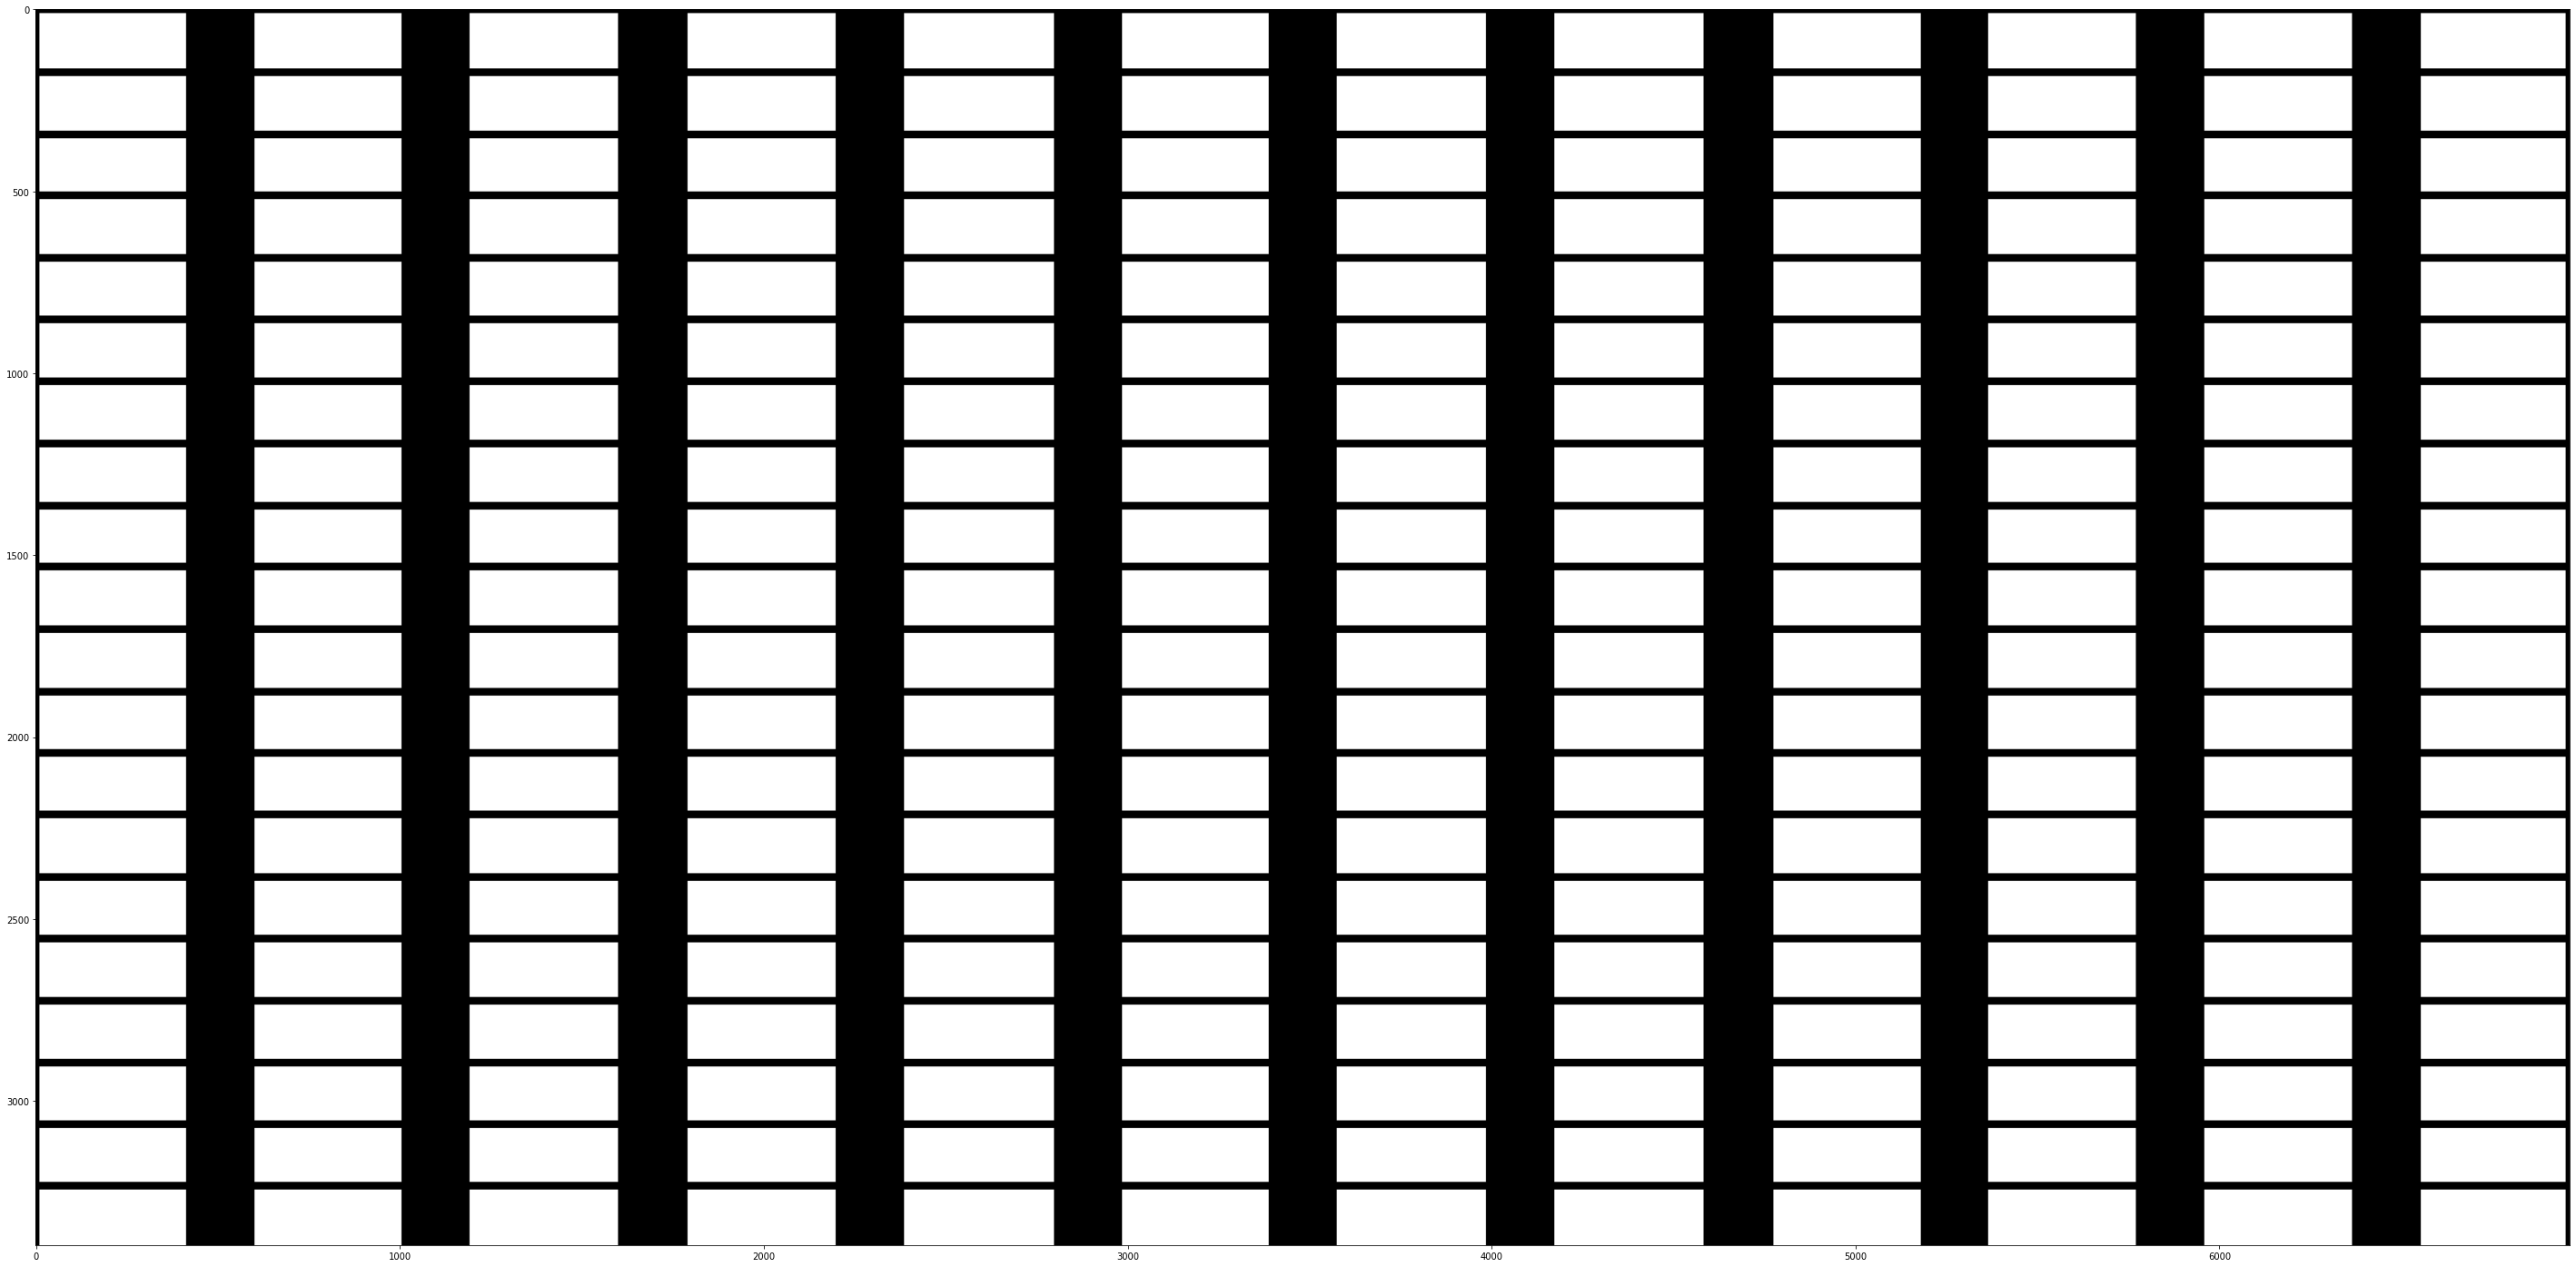

In [5]:
mask_line = io.imread(r"D:\Jizhou_UK\DFW\Late\las\mask_2.png")
selem = disk(7)
Grid_Image = dilation(mask_line, selem)

Grid_Segment = np.logical_not(Grid_Image) 
Grid_Segment_Refine = erosion(Grid_Segment, disk(3))

list_bbox_area = []
Labelled_Plot_Img_o, num_features_o = ndi.measurements.label(Grid_Segment_Refine)
for region in regionprops(Labelled_Plot_Img_o):
    list_bbox_area.append(region.area)
    
re_area = np.max(list_bbox_area)*0.5
print(re_area)

Grid_Segment_Refine = remove_small_objects(Grid_Segment_Refine, re_area)

fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(Grid_Segment_Refine, cmap=plt.cm.gray)

Labelled_Plot_Img, num_features = ndi.measurements.label(Grid_Segment_Refine)
print(num_features)

In [6]:
scal_f = 0.6  #scale factor

working_dir = r"D:\Jizhou_UK\DFW\Late\las\190711"
plot_las_dir = r"D:\Jizhou_UK\DFW\Late\las\190711\plot_las"
plot_num = 0

wbt = whitebox.WhiteboxTools()
wbt.set_working_dir(working_dir)
wbt.set_verbose_mode(False)

for region in tqdm(regionprops(Labelled_Plot_Img)):
    minr, minc, maxr, maxc = region.bbox
    
    col_val = ((maxc-minc)/2)*scal_f 
    row_val = ((maxr-minr)/2)*scal_f  
    
    minr_3d = region.centroid[0]-row_val
    minc_3d = region.centroid[1]-col_val
    maxr_3d = region.centroid[0]+row_val
    maxc_3d = region.centroid[1]+col_val
    
    #upper left
    upper_left_r = minr_3d
    upper_left_c = minc_3d
    #lower left
    lower_left_r = maxr_3d
    lower_left_c = minc_3d
    #upper right
    upper_right_r = minr_3d
    upper_right_c = maxc_3d
    #lower right
    lower_right_r = maxr_3d
    lower_right_c = maxc_3d
    
    points_ul = np.float32([[[upper_left_c, upper_left_r]]])
    points_ll = np.float32([[[lower_left_c, lower_left_r]]])
    points_ur = np.float32([[[upper_right_c, upper_right_r]]])
    points_lr = np.float32([[[lower_right_c, lower_right_r]]])
    
    transformed_ul = cv2.perspectiveTransform(points_ul, inverse_M_PT)
    transformed_ll = cv2.perspectiveTransform(points_ll, inverse_M_PT)
    transformed_ur = cv2.perspectiveTransform(points_ur, inverse_M_PT)
    transformed_lr = cv2.perspectiveTransform(points_lr, inverse_M_PT)
    
    plot_ul = dataset.transform *(transformed_ul[0,0,0],transformed_ul[0,0,1])
    plot_ll = dataset.transform *(transformed_ll[0,0,0],transformed_ll[0,0,1])
    plot_ur = dataset.transform *(transformed_ur[0,0,0],transformed_ur[0,0,1])
    plot_lr = dataset.transform *(transformed_lr[0,0,0],transformed_lr[0,0,1])
    
    driver = ogr.GetDriverByName("ESRI Shapefile")  
    data_source = driver.CreateDataSource(os.path.join(working_dir, 'polygon.shp'))
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(32431) 
    layer = data_source.CreateLayer("polygon", srs, ogr.wkbMultiPolygon) 
    feature = ogr.Feature(layer.GetLayerDefn())
    wkt = 'polygon((%f %f,%f %f,%f %f,%f %f,%f %f))' % (
        plot_ll[0],plot_ll[1], plot_lr[0],plot_lr[1], plot_ur[0],plot_ur[1], plot_ul[0],plot_ul[1], plot_ll[0],plot_ll[1])
    polygon = ogr.CreateGeometryFromWkt(wkt)
    feature.SetGeometry(polygon)
    layer.CreateFeature(feature)
    feature = None
    data_source = None
        
    wbt.clip_lidar_to_polygon(
            i=r"D:\Jizhou_UK\DFW\Late\las\190711\DFW_late_190711_sor_above_3d_ROI.las", 
            polygons='polygon.shp',
            output=plot_las_dir + '\\' + 'plot_'+str(plot_num)+'.las'
        )
    plot_num += 1

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [15:58<00:00,  3.99s/it]


In [7]:
# Take out the top 50% point clouds of height Z in batches and save them in TXT format
plot_txt_dir = r"D:\Jizhou_UK\DFW\Late\las\190711\plot_txt"
las_path = os.listdir(plot_las_dir)
for name in tqdm(range(len(las_path))):
    f_las = file.File(plot_las_dir+'\\'+las_path[name])
    index = np.argwhere(f_las.Z >= np.percentile(f_las.Z, 1))
    x = np.concatenate(f_las.X[index])
    y = np.concatenate(f_las.Y[index])
    z = np.concatenate(f_las.Z[index])
    r = np.concatenate(f_las.Red[index])
    g = np.concatenate(f_las.Green[index])
    b = np.concatenate(f_las.Blue[index])
    point_cloud = np.vstack((x, y, z, r, g, b)).transpose()
    min_val = np.min(point_cloud, axis = 0)
    r_min = min_val[3]
    g_min = min_val[4]
    b_min = min_val[5]
    max_val = np.max(point_cloud, axis = 0)
    r_max = max_val[3]
    g_max = max_val[4]
    b_max = max_val[5]
    for point in point_cloud:
        point[3] = (point[3] - r_min) / (r_max - r_min) * 255
        point[4] = (point[4] - g_min) / (g_max - g_min) * 255
        point[5] = (point[5] - b_min) / (b_max - b_min) * 255
    np.savetxt(plot_txt_dir+'\\'+las_path[name][:-3]+'txt', point_cloud, fmt = "%d")

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:40<00:00,  5.86it/s]


In [8]:
# LAI
lai_list = []
plot_txt_path = os.listdir(plot_txt_dir)
plot_txt_path.sort(key = lambda x : int(x.split('_')[1][:-4]))

for name in tqdm(range(len(plot_txt_path))):
    data = np.loadtxt(open(plot_txt_dir+'\\'+plot_txt_path[name],"rb"), 
                  delimiter = " ", usecols = (0, 1, 2), dtype = float, skiprows = 1)
    # Calculated mean distance
    x = data[:, 0]; y = data[:, 1]; z = data[:, 2]

    lasdata = zip(x,y,z)
    tree = spatial.cKDTree(list(lasdata))
    K=2   
    #Create an array of storage distances for each point field
    k_dist=np.zeros_like(x)
    #Find points that are less than what distance
    for i in range(len(x)):
        dist,index =tree.query(np.array([x[i],y[i],z[i]]), K)
        k_dist[i] = np.sum(dist)
    size_of_voxel = [1.5*np.mean(k_dist), 1.5*np.mean(k_dist), 1.5*np.mean(k_dist)]

    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)
    z_min = min(z)
    z_max = max(z)

    # Length, width and height of voxels
    voxel_Width = size_of_voxel[0]
    voxel_Long = size_of_voxel[1]
    voxel_Height = size_of_voxel[2]

    # Calculate the offset of each point in the x, y, and z directions
    x_Offset = np.ceil((x - x_min) / voxel_Width)
    y_Offset = np.ceil((y - y_min) / voxel_Long)
    z_Offset = np.ceil((z - z_min) / voxel_Height)

    # The number of voxels in the length, width and height directions of point cloud data was calculated
    rows = np.ceil((y_max - y_min) / voxel_Width)
    cols = np.ceil((x_max - x_min) / voxel_Long)
    heis = np.ceil((z_max - z_min) / voxel_Height)

    # Number of voxels per layer
    one_layer = rows * cols

    # Take the offset matrix of the three directions
    points = np.column_stack([x_Offset, y_Offset, z_Offset])
    points = np.array(points)

    # Matrix to heavy
    a = np.unique(points, axis = 0)

    pts = pd.DataFrame(a, columns = ['Off_x', 'Off_y', 'Off_z'])
    groups = pts.groupby(pts['Off_z'])

    layers = groups.size() / one_layer

    LAI = sum(layers) * 1.1
    lai_list.append(LAI)

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [03:41<00:00,  1.08it/s]


In [9]:
dt_lai = pd.DataFrame({'lai':lai_list})
dt_lai.to_csv(r"D:\Jizhou_UK\DFW\Late\las\190711\DFW_late_190711_lai.csv",encoding="gbk")